In [1]:
using Plots, LinearAlgebra, LaTeXStrings, SymPy, Random

In [2]:
Random.seed!(1234567890)

TaskLocalRNG()

# Tarea 2: Dinámica molecular

Esta tarea la iré complemntando hasta juntar unos 20 problemas. Por ahoro sólo harán 5

[1] Haz una simulación de gas de Lorenz periódico y mide: 
1. El exponente de Lyaponov de las partículas. Es decir, mide en promedio como se incrementa la distancia d(t) en el espacio fase de dos partículas con condiciones inicial es muy cercanas (con una variación fija en distancia inicial en el espacio fase de las condiciones iniciales). Después haz un ajuste a esa función d(t) usando una exponencial de la forma $A e^{\lambda t}$ y obten el valor de $\lambda$.  
2. El desplazamiento cuadrático medio de las partículas. Es decir, mide en promedio cuanto se separan de su posición inicial al pasar el tiempo. ¿El sistema es difusivo? 

Primero establecemos la simulación, la idea es utilizar lo que ya está hecho para discos duros y primero implementar una partícula móvil para el gas de Lorentz en una red cuadrada, después para una configuración inicial desordenada

In [3]:
# Establezcamos el sistema, el divide y venceras, las condiciones de frontera periódicas y las celdas 
mutable struct Particle
    posicion::Vector{Real}
    radio::Real
    L::Real
    celda::Int
    velocidad::Vector{Real}
end

function Particle(posicion, radio, L)
    n = floor(L/(2radio))
    l = L/n
    n_x, n_y = (posicion[1]÷l)+1, (posicion[1]÷l)
    n_celda = Int(n_x + (n_y)*n)
    vel = [0,0]
    Particle(posicion, radio, L, n_celda, vel)
end

# mutable struct Sistema_Periodico
#     L::Int64
#     radio_particulas::Float64
#     celdas::Vector{Int64}
# end

# function Sistema_Periodico(L,radio)
#     n = floor(L/(2radio))
#     l = L/n
#     celdas = [i for i in 1:n^2]
#     Sistema_Periodico(L,radio,celdas)
# end

Particle

In [4]:
import Base.+,Plots.plot, Plots.plot!

In [5]:
+(p::Particle, x::Vector) = Particle(p.posicion.+x, p.radio, p.L, p.celda, p.velocidad)

function distancia(p1::Particle, p2::Particle)
    x1 = p1.posicion
    x2 = p2.posicion
    norm(x1-x2)
end

function plot(particula::Particle;kargs...)
    x0 = particula.posicion
    r = particula.radio
    X = [r*cos(θ)+x0[1] for θ in 0:π/20:2π]
    Y = [r*sin(θ)+x0[2] for θ in 0:π/20:2π]
    plot(X,Y;kargs...)
end

function plot(particula::Particle, r;kargs...)
    x0 = particula.posicion
    X = [r*cos(θ)+x0[1] for θ in 0:π/20:2π]
    Y = [r*sin(θ)+x0[2] for θ in 0:π/20:2π]
    plot(X,Y;kargs...)
end

function plot!(particula::Particle;kargs...)
    x0 = particula.posicion
    r = particula.radio
    X = [r*cos(θ)+x0[1] for θ in 0:π/20:2π]
    Y = [r*sin(θ)+x0[2] for θ in 0:π/20:2π]
    plot!(X,Y;kargs...)
end

function plot!(particula::Particle, r;kargs...)
    x0 = particula.posicion
    X = [r*cos(θ)+x0[1] for θ in 0:π/20:2π]
    Y = [r*sin(θ)+x0[2] for θ in 0:π/20:2π]
    plot!(X,Y;kargs...)
end

function plot(particulas::Array{Particle};kargs...)
    plot()
    for p in particulas
        plot!(p;kargs...)
    end
    plot!(key = false, aspect_ratio = true)
end

function plot(particulas::Array{Particle}, r;kargs...)
    plot()
    for p in particulas
        plot!(p, r;kargs...)
    end
    plot!(key = false, aspect_ratio = true)
end

function plot!(particulas::Array{Particle};kargs...)
    for p in particulas
        plot!(p;kargs...)
    end
    plot!()
end

function plot!(particulas::Array{Particle}, r;kargs...)
    for p in particulas
        plot!(p, r;kargs...)
    end
    plot!()
end  

plot! (generic function with 8 methods)

In [6]:
function lista_de_vecinos(n,m)
    N = n*m
    vecinos = [[mod1(i+1, n)+floor(Int, (i-1)/n)*n,mod1(i-1, n)+floor(Int, (i-1)/n)*n, 
            mod1(i+n, N), mod1(i-n, N),
            mod1(mod1(i+1, n)+floor(Int, (i-1)/n)*n+n, N),mod1(mod1(i-1, n)+floor(Int, (i-1)/n)*n+n, N), 
            mod1(mod1(i+1, n)+floor(Int, (i-1)/n)*n-n, N), mod1(mod1(i-1, n)+floor(Int, (i-1)/n)*n-n, N)] for i in 1:N]
end

lista_de_vecinos(n) = lista_de_vecinos(n,n)

lista_de_vecinos (generic function with 2 methods)

In [7]:
function condiciones_inicials_cuadradas(L, r)
    posiciones = [[0.0, 0.0] for i in 1:L^2]
    for i in 1:L^2
        posiciones[i] = [mod1(i, L),ceil(i/L)] 
    end
    return [Particle(posiciones[i], r, L) for i in 1:L^2]
end

condiciones_inicials_cuadradas (generic function with 1 method)

In [8]:
celdas(n) = [[] for i in 1:n^2] 

function dibuja_celdas(L)
    # Asumiendo un sistema cuadrado
    intersecciones = collect(0.5:1:(L+0.5))
    hline!(intersecciones, lw=0.5,color=:red)
    vline!(intersecciones, lw=0.5,color=:red)
end

dibuja_celdas (generic function with 1 method)

In [9]:
L = 10
núcleos = condiciones_inicials_cuadradas(L, 0.5); 

celdas_p = celdas(L)
vecinos = lista_de_vecinos(L);

for i in 1:L^2
    nc = núcleos[i].celda    
    push!(celdas_p[nc], i)
end

LoadError: BoundsError: attempt to access 100-element Vector{Vector{Any}} at index [111]

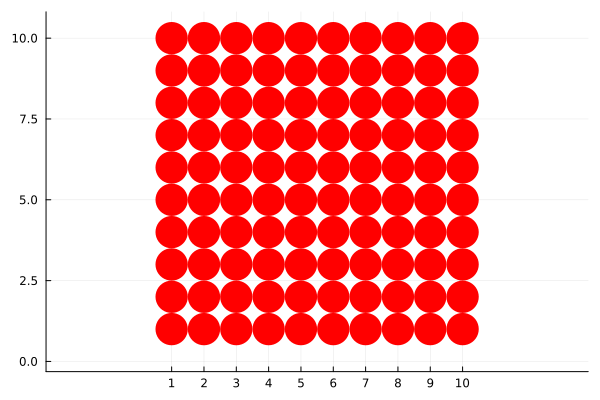

In [10]:
plot(núcleos, color = :red, lw = 0.0, xticks = 1:1:10,fill = true)

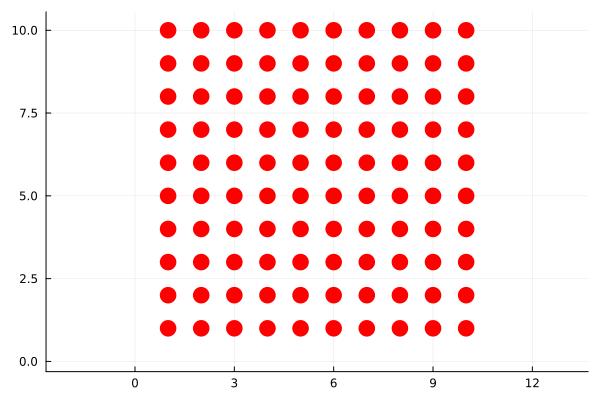

In [11]:
for p in núcleos
    p.radio = 0.25
end

plot(núcleos, color = :red, lw = 0.0, fill = true)

Diremos que las partículas móviles son "electrones" y definiremos sus trayectorias usando lo que tenemos para los obstáculos, a los que llamamos "núcleos"

Primero, definimos cómo se moverán los electrones, para ello necesitamos una posición inicial, una velocidad inicial,
la posición de los obstáculos y mantener la pista de la celda de la partícula y qué obstáculos están en la celda. Por
fortuna esto último está implementado en el objeto Particle.

Queremos implementar esto de forma que sea event drive, así que necesitamos calcular los timepos de los posibles eventos, estos son: La partícula llega a la frontera de una celda (4 tiempos posibles) o la partícula colisiona con un obstáculo (tiempo de colisión). Habrá que considerar el mínimo.

In [ ]:
@syms x0,y0,xc,yc,vx,vy,t,r

circle = sympy.Poly((x0 + vx*t - xc)^2 + (y0 + vy*t - yc)^2 - r^2,t)
circle.coeffs

In [ ]:
function tiempo_colision_frontera(x0, r0::Float64, θ::Float64)    
    # Distancia horizantal entre el electrón y la frontera:
    # Esto funciona porque la frontera de la celda está puesta en los números semienteros
    θ = mod(θ,2π)
#     (θ < π/2 || θ > 3*π/2) ? x_top = floor(x0[1])+0.5 : x_top = ceil(x0[1])-0.5
    if (θ < π/2 || θ > 3*π/2)
        x_top = floor(x0[1])+0.5
    else
        x_top = ceil(x0[1])-0.5
    end
    x = abs(x_top-x0[1]) 
    
    # Tiempo de colisión, asegurarse que siempre es positivo
    t = x/(abs(cos(θ)))*r0
    return t
end

function tiempo_colision_obstáculo(xi, vi, Xc, radio)
    # Xc es el vector de posición del obstáculo (núcleo)
    x0, y0, vx, vy, xc, yc, r = xi[1], xi[2], vi[1], vi[2], Xc[1], Xc[2], radio
    a = vx^2 + vy^2
    b = (vx*x0 - vx*xc + vy*y0 - vy*yc)/a
    c = (- r^2 + x0^2 - 2*x0*xc + xc^2 + y0^2 - 2*y0*yc + yc^2)/a
    if (b^2-c)<0
        t = Inf
    elseif (b + sqrt(b^2-c)) < 0
        t = Inf
    else 
        t = -(b + sqrt(b^2-c))
    end
    return t
end

function tiempo_a_evento(x0, v0, r0, θ, nc, radio, celdas, vecinos)
    # Calcular los tiempos de los posibles eventos:
    # Tiempo que tarda en cambiar de celda
    t_celda = tiempo_colision_frontera(x0, r0, θ)  
    
    # Tiempo que tarda en colisionar con obstáculos en la celda actual y aledañas
    celdas_a_revisar = [nc] ∪ vecinos[nc]
    t_obs = Inf
    dist = Inf
    nucleo_mas_cercano = 0
    
    for k in celdas_a_revisar
        indices = celdas[k]
        
        for j in indices
            Xc = núcleos[j].posicion
            t_new = tiempo_colision_obstáculo(x0, v0, Xc, radio)
            dist_new = norm(Xc-x0)
            (t_new < t_obs) && (t_obs = t_new)
            
            if dist_new<dist
                dist = dist_new
                nucleo_mas_cercano = j
            end
        end
    end
    
    # Encontrar el mínimo
    t = min(t_obs,t_celda)
    
    # Regresar el tiempo, el núcleo más cercano y si choca con un obstáculo, regresa el marcador 1
    if t_obs < t_celda
        return t, nucleo_mas_cercano, 1
    else
        return t, nucleo_mas_cercano, 0   
    end
end

In [ ]:
function choque_obstáculo(electrón, núcleo)
    #Función que tiene como argumentos el electron y el núcleo
    # y devuelve la velocidad final del electrón después del choque
    v0 = electrón.velocidad
    r = (electrón.posicion - núcleo.posicion)
    r /= norm(r)
    v_orto = dot(r,v0)*r
    vf = v0 - 2 .*v_orto
    return vf
end

function frontera_periódica1D(pos,region)
    # La región [a,b] debe cumplir con a<b
    if region[1]>region[2]
        region[1],region[2] = region[2],region[1]
    end
    
    if pos<region[1]
        dif = pos-region[1]  # Nota que es un número negativo
        new_pos = region[2]+dif
    elseif pos>region[2]
        dif = pos-region[2]
        new_pos = region[1]+dif
    else
        new_pos = pos
    end
    return new_pos
end

function frontera_periódica(pos,region)    
    new_pos = zeros(length(pos))
        
    for coord in 1:length(pos)
        new_pos[coord] = frontera_periódica1D(pos[coord],region)
    end
    return new_pos
end

function mueve_electrón(electrón::Particle, núcleos::Array{Particle}, celdas, vecinos
        ; δt = 0.000001)            
    # Parámetros de las partículas 
    x0, v0, radio_e, nc = electrón.posicion, electrón.velocidad, electrón.radio, electrón.celda
    radio_n = núcleos[1].radio
    L = núcleos[1].L
    
    # Calculamos la rapidez y el ángulo   
    r0 = norm(v0)
    θ = atan(v0[2]/v0[1])
    
    # Calcular el tiempo al evento más próximo
    t, ind_núcleo_más_cercano, hit_obs = tiempo_a_evento(x0, v0, r0, θ, nc, radio_n, celdas, vecinos)
    núcleo_más_cercano = núcleos[ind_núcleo_más_cercano]
    
    # Evoluciona posición y velocidad
    x_evol = mod.(x0 .+ t*v0, L)
    electrón2 = Particle(x_evol,0.5,L)   # Electrón auxiliar con la posición evolucinada para hacer los cálculos
                                         # sin tener que modificar al electrón original
    electrón2.radio = electrón.radio
    electrón2.velocidad = electrón.velocidad
    
    if hit_obs == 0
        v_evol = v0
    elseif hit_obs == 1
        v_evol = choque_obstáculo(electrón2, núcleo_más_cercano)
    end    
    
    δx_evol = frontera_periódica(x_evol + δt*v_evol, [0.5,(L+0.5)])
    
    return x_evol, v_evol, δx_evol
end

In [ ]:
# probemos la función con un sistema sencillo y con pocos pasos
L = 1
electrón = Particle([0.51,0.51],0.5,L)
núcleos = condiciones_inicials_cuadradas(L, 0.5); 

# Recuerda que es importante inicializar las condiciones iniciales cuadradas con radio igual a 0.5
# para que las celdas estén bien definidas

celdas_p = celdas(L)
vecinos = lista_de_vecinos(L);

for i in 1:L^2
    nc = núcleos[i].celda
    push!(celdas_p[nc], i)
end

electrón.radio = 0.025
for p in núcleos
    p.radio = 0.25
end

pasos = 10
trayectoria_X = zeros(pasos)
trayectoria_Y = zeros(pasos)
trayectoria_δX = zeros(pasos)
trayectoria_δY = zeros(pasos)
electrón.velocidad = rand(2)

for i in 1:pasos
    x_evol, v_evol, δx_evol = mueve_electrón(electrón, núcleos, celdas_p, vecinos)
    trayectoria_X[i], trayectoria_Y[i] = x_evol[1], x_evol[2]
    trayectoria_δX[i], trayectoria_δY[i] = δx_evol[1], δx_evol[2] 
    electrón.posicion .= δx_evol
    electrón.velocidad .= v_evol
end

In [ ]:
mn = 10
foo = collect(zip(trayectoria_X, trayectoria_Y))
bazoo = collect(zip(trayectoria_δX, trayectoria_δY))

#  scatter(foo[1:mn])
# plot!(foo[1:mn])

scatter(bazoo[1:mn])
plot!(bazoo[1:mn])
# plot(electrón, color = :blue, lw = 0.0, fill = true)
plot!(núcleos, color = :red, lw = 0.0, fill = true, 
    aspect_ratio=:equal, legend=false, alpha=0.2)  
xlims!(L-1,L+1)
ylims!(L-1,L+1)
dibuja_celdas(L)

In [ ]:
println(trayectoria_δX)
println(trayectoria_δY)

[2] Haz una simulación de un gas de Lorentz desordenado. Es decir, ahora la posición de los obstáculos debe seguir una distribución Poissoniana (es decir, se debe ver como una distribución homogenea donde sea que se encuentre la partícula). Para esto tendrás que hacer un sistema finito. En este caso los obstáculos se pueden encimar. En este sistema mide también el desplazamiento cuadrático medio. ¿Hay alguna diferencia con el caso anterior? 

[3] Gas de fotones. Haz una simulación donde pongas partículas a revotar en una "placa", es decir, la frontera de tu sistema debe estar dada por una imagen que cargues (como con lo de resolver ecuaciones diferenciales parciales). Además tus partículas deben guardar qué celdas visitaron y en qué tiempo iban. Finalmente, para cada celda suma sus fases usando $sin(\omega_1 t)$ donde $t$ es el tiempo que llevaba recorriendo la partícula cuando entró en la celda. 

[4] Considera un gas de Lorentz periódico, pero ahora las partículas están cargadas eléctricamente y hay un gradiente de campo eléctrico en la dirección de $x$. Cuál es la corriente eléctrica promedio como función de $x$ (haz la simulación). 

[5] Ahora agrega un campo magnético ortogonal al plano de movimiento de las partículas, es decir, ahora las partículas se mueven formando círculos. ¿Cómo cambia la corriente eléctrica (el desplazamiento cuadrático medio) como función del campo magnético?